In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import chime

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('-'*20, 'train data', '-'*20)
train_df.info()

-------------------- train data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Correlation of target and categorical features

In [5]:
train_df['Title'] = train_df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
train_df['Married'] = 0
train_df['Married'].loc[train_df['Title'] == 'Mrs'] = 1
train_df['Title'] = train_df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
train_df['Title'] = train_df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

test_df['Title'] = test_df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
test_df['Married'] = 0
test_df['Married'].loc[test_df['Title'] == 'Mrs'] = 1
test_df['Title'] = test_df['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
test_df['Title'] = test_df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
train_df[['Title','Survived']].groupby(['Title'], as_index=False).mean()

C:\Users\limao\AppData\Local\Temp\ipykernel_15692\2814633723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Married'].loc[train_df['Title'] == 'Mrs'] = 1
C:\Users\limao\AppData\Local\Temp\ipykernel_15692\2814633723.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Married'].loc[test_df['Title'] == 'Mrs'] = 1


,Title,Survived
0,Dr/Military/Noble/Clergy,0.285714
1,Master,0.575000
2,Miss/Mrs/Ms,0.741214
3,Mr,0.156673


In [6]:
train_df[['Married','Survived']].groupby(['Married'], as_index=False).mean()

,Married,Survived
0,0,0.317232
1,1,0.792000


In [7]:
train_df[['Pclass','Survived']].groupby(['Pclass'], as_index=False).mean()

# passenger class has impact on survivability

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
train_df[['Embarked','Survived']].groupby(['Embarked'], as_index=False).mean()

# embark has impact on survivability

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [9]:
# creating 2 new features
# - combining SibSp and Parch to total number of family members
# - the passenger is alone on the ship
train_df['NumRelatives'] = train_df['SibSp'] + train_df['Parch']

train_df['Alone'] = np.where(train_df.NumRelatives == 0, 1, 0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Married,NumRelatives,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Miss/Mrs/Ms,1,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss/Mrs/Ms,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Miss/Mrs/Ms,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1


In [10]:
train_df[['NumRelatives','Survived']].groupby(['NumRelatives'], as_index=False).mean('Survived')

# number of relatives has low impact on survivability

,NumRelatives,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.724138
4,4,0.200000
5,5,0.136364
6,6,0.333333
7,7,0.000000
8,10,0.000000


In [11]:
train_df[['Alone','Survived']].groupby(['Alone'], as_index=False).mean('Survived')

# flag alone has good impact on survivability

,Alone,Survived
0,0,0.505650
1,1,0.303538


In [12]:
# drop NumRelatives and replicate Alone on test data
train_df = train_df.drop('NumRelatives', axis=1)

test_df['Alone'] = np.where(test_df.SibSp + test_df.Parch == 0, 1, 0)

In [13]:
# drop useless columns
train_df = train_df.drop(['Ticket', 'Cabin', 'Name', 'SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin', 'Name', 'SibSp', 'Parch'], axis=1)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,1,0,3,male,22.0,7.2500,S,Mr,0,0
1,2,1,1,female,38.0,71.2833,C,Miss/Mrs/Ms,1,0
2,3,1,3,female,26.0,7.9250,S,Miss/Mrs/Ms,0,1
3,4,1,1,female,35.0,53.1000,S,Miss/Mrs/Ms,1,0
4,5,0,3,male,35.0,8.0500,S,Mr,0,1


In [14]:
# encoding categorical features
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1}).astype(int)
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1}).astype(int)
# train_df['Embarked'] = train_df['Embarked'].map({'S': 1, 'Q': 2, 'C': 3}).astype(int)



In [15]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,1,0,3,0,22.0,7.2500,S,Mr,0,0
1,2,1,1,1,38.0,71.2833,C,Miss/Mrs/Ms,1,0
2,3,1,3,1,26.0,7.9250,S,Miss/Mrs/Ms,0,1
3,4,1,1,1,35.0,53.1000,S,Miss/Mrs/Ms,1,0
4,5,0,3,0,35.0,8.0500,S,Mr,0,1


In [16]:
ages = np.zeros((2,3))

def fill_age(df):

    for i in range(0, 2):
        for j in range(0, 3):

            temp_df = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna()

            temp_age = temp_df.median()
            ages[i,j] = int(temp_age/0.5 + 0.5)*0.5

    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), 'Age' ] = ages[i,j]

    df['Age'] = df['Age'].astype(int)

    return df

In [17]:
train_df = fill_age(train_df)
test_df = fill_age(test_df)

train_df['AgeRange'] = pd.cut(train_df['Age'], 5)

train_df[['AgeRange','Survived']].groupby(['AgeRange'], as_index=False).mean()

,AgeRange,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [18]:
def encode_age(df):
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[ (df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[ (df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[ (df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ (df['Age'] > 64), 'Age'] = 4
    
    return df

train_df = encode_age(train_df).drop('AgeRange', axis = 1)
test_df = encode_age(test_df)

train_df.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,1,0,3,0,1,7.2500,S,Mr,0,0
1,2,1,1,1,2,71.2833,C,Miss/Mrs/Ms,1,0
2,3,1,3,1,1,7.9250,S,Miss/Mrs/Ms,0,1
3,4,1,1,1,2,53.1000,S,Miss/Mrs/Ms,1,0
4,5,0,3,0,2,8.0500,S,Mr,0,1


In [19]:
def encode_title(df):
    df.loc[ df['Title'] == 'Mr', 'Title'] = 0
    df.loc[ df['Title'] == 'Dr/Military/Noble/Clergy' , 'Title'] = 1
    df.loc[ df['Title'] == 'Master', 'Title'] = 2
    df.loc[ df['Title'] == 'Miss/Mrs/Ms', 'Title'] = 3
    
    return df

train_df = encode_title(train_df).astype({'Title':'int32'})
test_df = encode_title(test_df).astype({'Title':'int32'})

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,1,0,3,0,1,7.2500,S,0,0,0
1,2,1,1,1,2,71.2833,C,3,1,0
2,3,1,3,1,1,7.9250,S,3,0,1
3,4,1,1,1,2,53.1000,S,3,1,0
4,5,0,3,0,2,8.0500,S,0,0,1


In [20]:
# filling null values on enbarked
train_df['Embarked'] = train_df['Embarked'].fillna('S')

# encoding 
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)

In [21]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['FareRange'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareRange', 'Survived']].groupby(['FareRange'], as_index=False).mean()

,FareRange,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [22]:
def encode_fare(df):
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[ (df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[ (df['Fare'] > 14.454) & (df['Fare'] <= 31.0), 'Fare'] = 2
    df.loc[ (df['Fare'] > 31.0), 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)
    
    return df

train_df = encode_fare(train_df).drop('FareRange', axis = 1)
test_df = encode_fare(test_df)

train_df.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,1,0,3,0,1,0,0,0,0,0
1,2,1,1,1,2,3,2,3,1,0
2,3,1,3,1,1,1,0,3,0,1
3,4,1,1,1,2,3,0,3,1,0
4,5,0,3,0,2,1,0,0,0,1


In [23]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,892,3,0,2,0,1,0,0,1
1,893,3,1,2,0,0,3,1,0
2,894,2,0,3,1,1,0,0,1
3,895,3,0,1,1,0,0,0,1
4,896,3,1,1,1,0,3,1,0


### Data is ready for modeling

In [24]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [25]:
train_scale = StandardScaler().fit_transform(train_df.drop(["Survived", "PassengerId"], axis = 1))
train_df_scale = pd.DataFrame(train_scale, columns = ['Pclass','Sex','Age','Fare','Embarked','Title','Married','Alone'])
train_df_scale['Survived'] = train_df['Survived']
train_df_scale

test_scale = StandardScaler().fit_transform(test_df.drop(["PassengerId"], axis = 1))
test_df_scale = pd.DataFrame(test_scale, columns = ['Pclass','Sex','Age','Fare','Embarked','Title','Married','Alone'])
test_df_scale['PassengerId'] = test_df['PassengerId']
test_df_scale

,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone,PassengerId
0,0.873482,-0.755929,0.887379,-1.301148,0.470915,-0.843010,-0.456172,0.807573,892
1,0.873482,1.322876,0.887379,-1.301148,-0.700767,1.258649,2.192158,-1.238278,893
2,-0.315819,-0.755929,2.193450,-0.428147,0.470915,-0.843010,-0.456172,0.807573,894
3,0.873482,-0.755929,-0.418693,-0.428147,-0.700767,-0.843010,-0.456172,0.807573,895
4,0.873482,1.322876,-0.418693,-0.428147,-0.700767,1.258649,2.192158,-1.238278,896
...,...,...,...,...,...,...,...,...,...
413,0.873482,-0.755929,-0.418693,-0.428147,-0.700767,-0.843010,-0.456172,0.807573,1305
414,-1.505120,1.322876,0.887379,1.317856,1.642598,1.258649,-0.456172,0.807573,1306
415,0.873482,-0.755929,0.887379,-1.301148,-0.700767,-0.843010,-0.456172,0.807573,1307
416,0.873482,-0.755929,-0.418693,-0.428147,-0.700767,-0.843010,-0.456172,0.807573,1308


In [26]:
x_train, x_validation, y_train, y_validation = train_test_split(train_df_scale.drop(["Survived"], axis = 1), train_df_scale["Survived"], test_size=0.2, random_state=42)

x_train

,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
331,-1.566107,-0.737695,0.827078,0.442900,-0.585954,-0.824873,-0.403962,0.811922
733,-0.369365,-0.737695,-0.392999,-0.451938,-0.585954,-0.824873,-0.403962,0.811922
382,0.827377,-0.737695,-0.392999,-0.451938,-0.585954,-0.824873,-0.403962,0.811922
704,0.827377,-0.737695,-0.392999,-1.346777,-0.585954,-0.824873,-0.403962,-1.231645
813,0.827377,1.355574,-1.613075,1.337738,-0.585954,1.295209,-0.403962,-1.231645
...,...,...,...,...,...,...,...,...
106,0.827377,1.355574,-0.392999,-1.346777,-0.585954,1.295209,-0.403962,0.811922
270,-1.566107,-0.737695,0.827078,0.442900,-0.585954,-0.824873,-0.403962,0.811922
860,0.827377,-0.737695,0.827078,-0.451938,-0.585954,-0.824873,-0.403962,-1.231645
435,-1.566107,1.355574,-1.613075,1.337738,-0.585954,1.295209,-0.403962,-1.231645


In [27]:
y_train

331    0
733    0
382    0
704    0
813    0
      ..
106    1
270    0
860    0
435    1
102    0
Name: Survived, Length: 712, dtype: int64

## Regressão logistica

Logistic regression
Accuracy: 0.78


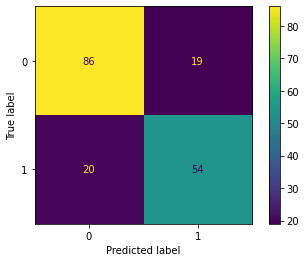

In [28]:
m_logreg = LogisticRegression(random_state=42)
m_logreg = m_logreg.fit(x_train, y_train)

pred_logreg = m_logreg.predict(x_validation)

cm = confusion_matrix(y_validation, pred_logreg, labels=m_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=m_logreg.classes_)
disp.plot()
print("Logistic regression\nAccuracy:", round(accuracy_score(y_validation, pred_logreg), 2) )

## Random forest

Random forest
Accuracy: 0.81


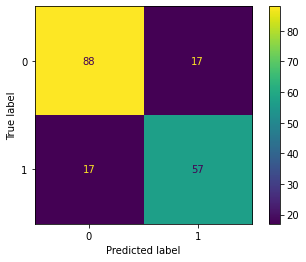

In [29]:
m_rf = RandomForestClassifier()
m_rf = m_rf.fit(x_train, y_train)


pred_rf = m_rf.predict(x_validation)

cm = confusion_matrix(y_validation, pred_rf, labels=m_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=m_rf.classes_)
disp.plot()
print("Random forest\nAccuracy:", round(accuracy_score(y_validation, pred_rf), 2) )

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\limao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random forest after hypertuning
Accuracy-score: 0.79


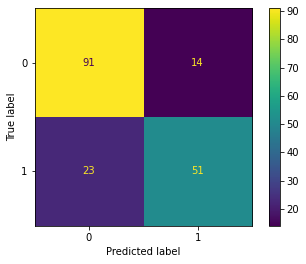

In [30]:
# tuning random forest hyperparameters

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt']
# max number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 30, num = 15)]
max_depth.append(None)
# min number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

m_rf_tuned = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = m_rf_tuned, scoring='accuracy', param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

pred_rf_tuned = rf_random.predict(x_validation)

cm = confusion_matrix(y_validation, pred_rf_tuned, labels=rf_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_random.classes_)
disp.plot()
print("Random forest after hypertuning\nAccuracy-score:", round(accuracy_score(y_validation, pred_rf_tuned), 2) )

## Xgboost

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Xgboost with hypertuning
Accuracy: 0.79


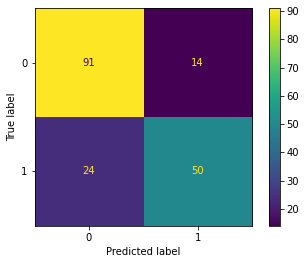

In [31]:
m_xgb = xgb.XGBClassifier()

random_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
               'min_child_weight': [1, 3, 5, 7],
               'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
               'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

xgb_random = RandomizedSearchCV(estimator = m_xgb, scoring='accuracy', param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
xgb_random.fit(x_train, y_train)

pred_xgb_tuned = xgb_random.predict(x_validation)

cm = confusion_matrix(y_validation, pred_xgb_tuned, labels=xgb_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_random.classes_)
disp.plot()
print("Xgboost with hypertuning\nAccuracy:", round(accuracy_score(y_validation, pred_xgb_tuned), 2) )


Seguirei com o modelo resultante do xgboost com fine tuning dos parametros

In [37]:
# y_test_out = m_logreg.predict(test_df_scale.drop('PassengerId', axis = 1))
# y_test_out = rf_random.predict(test_df_scale.drop("PassengerId", axis = 1))
y_test_out = xgb_random.predict(test_df_scale.drop("PassengerId", axis = 1))

In [33]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,Married,Alone
0,892,3,0,2,0,1,0,0,1
1,893,3,1,2,0,0,3,1,0
2,894,2,0,3,1,1,0,0,1
3,895,3,0,1,1,0,0,0,1
4,896,3,1,1,1,0,3,1,0


In [38]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': y_test_out})
output.to_csv('submission.csv', index=False)